In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [19]:
from biom.table import Table
from qiime2 import Artifact
from qiime2.plugins import feature_table, longitudinal, diversity


In [20]:
%matplotlib inline

# Prepara Data

## Convert the data from the pickle format to BIOM.

The mouse data is filtered and is split up into two different sets: 4 healthy mice and 5 IBD mice. Each dataset has been stored in a pickle file. The aim of this section is to load the data, merge it into a single dataframe, containing all the experiment data, with each row representing an OTU.

**Load Pickle Files**

The function below reads the pickle files and store the content into variables.

In [6]:
data_folder = '../Microbiome_Module_Material/Part c full processed data/'

In [7]:
def get_data(set_nr=1):
    with open(data_folder + 'mouse_set_' + str(set_nr) + '_data.pkl', 'rb') as handle:
        mouse_set = pickle.load(handle)    
    reads = mouse_set['reads']
    qpcr = mouse_set['qpcr']
    otu_taxonomy = mouse_set['otu_taxonomy']
    times = mouse_set['times']
    return reads, qpcr, otu_taxonomy, times

In [8]:
reads_1, qpcr_1, otu_taxonomy_1, times_1 = get_data(1)
reads_2, qpcr_2, otu_taxonomy_2, times_2 = get_data(2)

**Create a merged dataframe**

The function below merges the data about reads, qPCR, OTU taxonomy assigment into a single dataframe.
It additionally compute the experiment phase, the day, the hour, the sample id.

In [197]:
df_all = pd.DataFrame(columns=["group", "mouse","phase","day","hour","time_i","time_str","sample","otu","sequence","abundance","total_abundance","qpcr","mass","kingdom","phylum","class","order","family","genus"])

In [265]:
def load_mouse_dataset(df, group, reads, qpcr, otu_taxonomy, times):
    nb = df.shape[0]
    for mouse_nr, mouse_reads in reads.items():
        for i, time_str in enumerate(mouse_reads.columns):
            mouse = mouse_nr
            time_i = times[i]
            qpcr_val = qpcr[mouse_nr].loc[time_str]['mean']
            total_abundance = 0
            nb_sub = nb
            for otu, abundance in mouse_reads[time_str].iteritems():
                total_abundance += abundance
                phase = 1 if time_i<21.5 else 2 if time_i<28.5 else 3 if time_i<35.5 else 4 if time_i<42.5 else 5 if time_i<50.5 else 6 if time_i<57.5 else 7
                day = time_str.replace('AM','').replace('AM','')
                hour = 'AM' if 'AM' in time_str else 'PM'
                sampleid = str(mouse) + 'd' + time_str.lower()
                seq = otu_taxonomy.loc[otu].sequence
                df.loc[nb] = [group, mouse_nr, phase, day, hour, time_i, time_str, 
                              sampleid, otu, seq, abundance, total_abundance, qpcr_val, qpcr_val,
                                 otu_taxonomy.loc[otu].Kingdom,
                                 otu_taxonomy.loc[otu].Phylum,
                                 otu_taxonomy.loc[otu].Class,
                                 otu_taxonomy.loc[otu].Order,
                                 otu_taxonomy.loc[otu].Family,
                                 otu_taxonomy.loc[otu].Genus]
                nb += 1
            df.loc[nb_sub:nb, 'mass'] = df.loc[nb_sub:nb].abundance * (qpcr_val/total_abundance) 
            df.loc[nb_sub:nb, 'total_abundance'] = total_abundance 
            #print("{} {} {}".format(mouse_nr, time_str, df.shape[0]))
    return df

In [280]:
df_all = load_mouse_dataset(df_all, 1, reads_1, qpcr_1, otu_taxonomy_1, times_1)

In [281]:
df_all = load_mouse_dataset(df_all, 2, reads_2, qpcr_2, otu_taxonomy_2, times_2)

In [282]:
#df_all.to_pickle(data_folder + 'mouse_set_data_merged_20190508.pkl')

In [323]:
df_all[df_all.columns.difference(['total_abundance'])].head(3)

,abundance,class,day,family,genus,group,hour,kingdom,mass,mouse,order,otu,phase,phylum,qpcr,sample,sequence,time_i,time_str
0,1094,Bacteroidia,0,Bacteroidaceae,Bacteroides,1,AM,Bacteria,3.258519e+06,2,Bacteroidales,OTU_1,1,Bacteroidetes,8.724134e+06,2d0am,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,0.0,0AM
1,180,Bacteroidia,0,Bacteroidaceae,Bacteroides,1,AM,Bacteria,5.361366e+05,2,Bacteroidales,OTU_2,1,Bacteroidetes,8.724134e+06,2d0am,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,0.0,0AM
2,10,Verrucomicrobiae,0,Verrucomicrobiaceae,Akkermansia,1,AM,Bacteria,2.978537e+04,2,Verrucomicrobiales,OTU_3,1,Verrucomicrobia,8.724134e+06,2d0am,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,0.0,0AM


In [321]:
df_all.shape

(298806, 20)

In [ ]:
'''
data_folder = '../Microbiome_Module_Material/Part c full processed data/'
with open(data_folder + 'mouse_set_data_merged_20190508.pkl', 'rb') as handle:
    df_all = pickle.load(handle)    
df_all.head()
'''

**Save as BIOM file**

In order to conduct microbiome analysis in common platforms such as QIIME, we need to convert the data in a BIOM format. The BIOM file format (canonically pronounced biome) is designed to be a general-use format for representing biological sample by observation contingency tables. BIOM is a recognized standard for the Earth Microbiome Project and is a Genomics Standards Consortium supported project. 

The Biological Observation Matrix (BIOM) format or: how I learned to stop worrying and love the ome-ome.
Daniel McDonald, Jose C. Clemente, Justin Kuczynski, Jai Ram Rideout, Jesse Stombaugh, Doug Wendel, Andreas Wilke, Susan Huse, John Hufnagle, Folker Meyer, Rob Knight, and J. Gregory Caporaso.
GigaScience 2012, 1:7. doi:10.1186/2047-217X-1-7


We first create the BIOM rows list.

In [146]:
rows = df_all[['otu','sequence', 'kingdom','phylum','class','order','family','genus']].groupby('otu').max().reset_index()
rows['id']=rows.otu.str.replace('OTU_','').astype(int)
rows = rows.sort_values(by='id')

In [147]:
rows_list = [{"id": r.otu, 
              "metadata": {"taxonomy": "k__{}; p__{}; c__{}; o__{}; f__{}; g__{}".format(r.kingdom,
                                                                                         r.phylum,
                                                                                         r['class'],
                                                                                         r.order,
                                                                                         r.family,
                                                                                         r.genus),
                           "sequence": r.sequence
                          }
             } for i, r in rows.iterrows()]

We create the BIOM columns list.

In [171]:
columns = df_all[['sample','mouse','group','phase','day','hour','time_i','time_str','qpcr']].groupby('sample').max().reset_index().rename(columns={'sample':'sampleid'})
columns = columns.sort_values(by=['mouse','group','phase','time_i','day','hour'])
columns.mouse = columns.mouse.astype(str)
columns.phase = columns.phase.astype(str)
columns.group = columns.group.astype(str)
columns.mouse = 'mouse_0' + columns.mouse
columns.mouse = columns.mouse.str.replace('010','10')
columns.phase = 'phase_' + columns.phase
columns.group = columns.group.apply(lambda g: 'IBD' if g=='2' else 'Healthy')

The abundance is stored in a dense matrix as follows. 

In [ ]:
data = []
nb = 0
for i,row in rows.iterrows():
    df_row = df_all[df_all.otu==row.otu]
    r = []
    for j,col in columns.iterrows():
        df = df_row[df_row['sample']==col.sampleid]
        if df.shape[0]==0:
            r.append(0)
        else:
            r.append(df.iloc[0].abundance)
    data.append(r)
    nb = nb + 1
    #print(nb)

The BIOM data file is created as JSON.

In [ ]:
biom_data = {
 "id":"ID",
 "format": "Biological Observation Matrix 0.9.1-dev",
 "format_url": "http://biom-format.org/documentation/format_versions/biom-1.0.html",
 "type": "OTU table",
 "generated_by": "Python",
 "date": "2019-05-05T19:00:00",
 "rows":rows_list,
 "columns": columns_list,
 "matrix_type": "dense",
 "matrix_element_type": "int",
 "shape": [len(rows),len(columns)],
 "data": data
}

In [ ]:
import json
with open('mouse_set_data_merged.biom', 'w') as fout:
    json.dump(biom_data , fout)

We also store the sample information in a metadata file.

In [ ]:
columns.to_csv('mouse_set_metadata.tsv', sep='\t', index=False)

We also recosntruct the FASTA sequence file as follows.

In [ ]:
with open('mouse_set_data-dna-sequences.fasta', 'a') as the_file:
    for i, r in rows.iterrows():
        the_file.write('>' + r.otu + '\n' + r.sequence + '\n')

# Analysis in QIIME

QIIME 2 is a powerful, extensible, and decentralized microbiome analysis package with a focus on data and analysis transparency.

Installing QIIME 2 on JupyterHub is straightforward, via terminal. The following command creates a new environement and installs the packages required by QUIIME.

`wget https://data.qiime2.org/distro/core/qiime2-2019.4-py36-linux-conda.yml`

`conda env create -n qiime2-2019.4 --file qiime2-2019.4-py36-linux-conda.yml`

`source activate qiime2-2019.4`


## Convert the data QIIME2 format.

Data handled by QIIME 2 exist as QIIME 2 artifacts. A QIIME 2 artifact contains data and metadata. The metadata describes things about the data, such as its type, format, and how it was generated (provenance). A QIIME 2 artifact typically has the .qza file extension when stored in a file. The metadata file has the .tsv extension.

The following command convert our BIOM file `mouse_set_data_merged.biom`, previously created to a QIIME artifact file `mouse_set_data_merged.qza`.

In [23]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime tools import \
  --input-path mouse_set_data_merged.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV100Format \
  --output-path mouse_set_data_merged.qza

Imported ../Microbiome_Module_Material/Part c full processed data/mouse_set_data_merged.biom as BIOMV100Format to mouse_set_data_merged2.qza


The following command created a visualization of our data using metadata information previousy stored in `mouse_set_metadata.tsv`. Visualizations are another type of data generated by QIIME 2. When written to disk, visualization files typically have the .qzv file extension. They can include statistical results table, an interactive visualization, static image, etc. We can use https://view.qiime2.org to easily view QIIME 2 artifacts and visualizations files.

In [263]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table summarize \
  --i-table mouse_set_data_merged.qza \
  --o-visualization mouse_set_data_merged.qzv \
  --m-sample-metadata-file mouse_set_metadata.tsv

Saved Visualization to: mouse_set_data_merged.qzv


Below we observe the number of samples recorded per experimental phase. 
![](images/barchart_samples_per_phase.jpg)

The number of sequences (reads) recorded from all mice distributed normally around mean 60,000 per sample. We have 665 samples, 279 features, 38,113,920 total frequency. The smallest sample has 74 frequency, the biggest samples has 143,766 frequency, the average is 57,314. The less occuring feature has frequency 131. The moast occuring feature has frequency 5,965,486, while the average per feature is 136,609.


![](images/sample-frequencies.jpg)


Additionally to the OTU table and samples metadata, we need the original sequence for each sample in order to analyze the microbiome data with phylogenic insight. We use our sequences FASTA file `mouse_set_data-dna-sequences` to manually create a QIIME sequence artifact file `mouse_set_data_merged-seqs.qza`. 

## Alpha and beta diversity analysis

QIIME supports several phylogenetic diversity metrics, including Faith’s Phylogenetic Diversity (expressed as the number of tree units which are found in a sample) as well as weighted and unweighted UniFrac. In addition to counts of features, these metrics require a rooted phylogenetic tree relating the features to one another. 

First, the pipeline uses the mafft program to perform a multiple sequence alignment of the sequences. Next, the pipeline filters the alignment to remove positions that are highly variable. Following that, the pipeline applies FastTree to generate a phylogenetic tree from the masked alignment. The FastTree program creates an unrooted tree, as well as a rooted tree by placing the root of the tree at the midpoint of the longest tip-to-tip distance in the unrooted tree. The rooted tree is stored as QIIME artifact in the file `mouse_set_data_merged-rooted-tree.qza`.

In [ ]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences mouse_set_data_merged-seqs.qza \
  --o-alignment aligned-rep-seqs.qza \
  --o-masked-alignment masked-aligned-rep-seqs.qza \
  --o-tree unrooted-tree.qza \
  --o-rooted-tree mouse_set_data_merged-rooted-tree.qza

For diversity analyses the QIIME first rarefies the OTU table to a user-specified depth, computes several alpha and beta diversity metrics, and generates principle coordinates analysis (PCoA) plots using Emperor for each of the beta diversity metrics. Because most diversity metrics are sensitive to different sampling depths across different samples, this script will randomly subsample the counts from each sample to the value provided as parameter. We choose a value that is as high as possible (so we retain more sequences per sample) while excluding as few samples as possible.

In [29]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity core-metrics-phylogenetic \
  --i-phylogeny mouse_set_data_merged-rooted-tree.qza \
  --i-table mouse_set_data_merged.qza \
  --p-sampling-depth 10000 \
  --m-metadata-file mouse_set_metadata.tsv \
  --output-dir mouse-core-metrics-results
  

Saved FeatureTable[Frequency] to: mouse-core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: mouse-core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: mouse-core-metrics-results/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: mouse-core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: mouse-core-metrics-results/evenness_vector.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: mouse-core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: mouse-core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: mouse-core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: mouse-core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: mouse-core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: mouse-core-metrics-results/weighted_

After computing diversity metrics, we can begin to explore the microbial composition of the samples in the context of the sample metadata. This information is present in the sample metadata file `mouse_set_metadata.tsv`.

We’ll first test for associations between categorical metadata columns and alpha diversity data. We’ll do that here for the Faith Phylogenetic Diversity (a measure of community richness) and evenness metrics.

In [36]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity alpha-group-significance \
  --i-alpha-diversity mouse-core-metrics-results/faith_pd_vector.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --o-visualization mouse-core-metrics-results/mouse_set-faith-pd-group-significance.qzv

Saved Visualization to: mouse-core-metrics-results/mouse_set-faith-pd-group-significance.qzv


As seen below, **health status is the categorical sample metadata column that is most strongly associated with the differences in microbial community richness.**

![](images/alpha-diversity-boxplot_mouse.jpg)

Richness significantly increases in phase 2 (High Fat Diet). Alpha diversity tells about the diversity (richness) within each individual sample: how many species are present, how much of the phylogenetic tree is covered. When comparing groups of samples (e.g., experimental phase, with a Kruskal-Wallis test), we are testing how richness differs between groups. In phase 2 (high fat diet), we notice more unique species/phylotypes within each individual mouse than in any other phase. The difference with phase 1 is significant with P value 2e-04, 4e-05 for phase 3, 3.6e-12 for phase 4, etc. Gram+ ABX antibiotics significantly reduces alpha diversity in phase 4, richness is the lowest during antibiotics treatement and also during the following washout phase. Diversity reduction is also visible during antibiotics treatement with Gram- ABX in phase 6, but with a far lesser extend than when mice where treated with Gram+ antibiotics. This suggests that **individual mice have more Gram+ bateria species than Gram- bacteria species.**

![](images/alpha-diversity-boxplot_phase.jpg)

We analyze sample composition in the context of categorical metadata using PERMANOVA. Below we test whether distances between samples from a healthy mouse, are more similar to each other than they are to samples from IBD mice. 

In [38]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity beta-group-significance \
  --i-distance-matrix mouse-core-metrics-results/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --o-visualization mouse-core-metrics-results/unweighted-unifrac-group-significance.qzv \
  --p-pairwise

Saved Visualization to: mouse-core-metrics-results/unweighted-unifrac-group-significance.qzv


Microbial composition is statistically different between healthy and disease mice with p<0.001.

![](images/group-significance-plot.jpg)

In [272]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "(phase='phase_1' and \"group\"='IBD') or (phase='phase_7' and \"group\"='Healthy')" \
  --o-filtered-table mouse_set_data_merged_IBD_Dev.qza

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity core-metrics-phylogenetic \
  --i-phylogeny mouse_set_data_merged-rooted-tree.qza \
  --i-table mouse_set_data_merged_IBD_Dev.qza \
  --p-sampling-depth 10000 \
  --m-metadata-file mouse_set_metadata.tsv \
  --output-dir mouse-core-metrics-results_IBD_Dev
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity alpha-group-significance \
  --i-alpha-diversity mouse-core-metrics-results_IBD_Dev/faith_pd_vector.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --o-visualization mouse-core-metrics-results_IBD_Dev/mouse_set-faith-pd-group-significance.qzv

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity beta-group-significance \
  --i-distance-matrix mouse-core-metrics-results_IBD_Dev/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --o-visualization mouse-core-metrics-results_IBD_Dev/unweighted-unifrac-group-significance.qzv \
  --p-pairwise

Saved FeatureTable[Frequency] to: mouse_set_data_merged_IBD_Dev.qza
Saved FeatureTable[Frequency] to: mouse-core-metrics-results_IBD_Dev/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: mouse-core-metrics-results_IBD_Dev/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: mouse-core-metrics-results_IBD_Dev/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: mouse-core-metrics-results_IBD_Dev/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: mouse-core-metrics-results_IBD_Dev/evenness_vector.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: mouse-core-metrics-results_IBD_Dev/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: mouse-core-metrics-results_IBD_Dev/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: mouse-core-metrics-results_IBD_Dev/jaccard_distance_matrix.qza
Saved DistanceMatrix to: mouse-core-metrics-results_IBD_Dev/bray_curtis_distance_matrix.qza
Sav



![](images/alpha-diversity-boxplot-healthy_phase7-vs-ibd_phase1.jpg)


![](images/beta-diversity-boxplot-healthy_phase7-vs-ibd_phase1.jpg)

## Taxonomic analysis

In order to explore the taxonomic composition of the samples, we first assign taxonomy to the sequences using the trained classifier `gg-13-8-99-515-806-nb-classifier.qza` provided by QIIME. We can generate a visualization of the resulting mapping from sequence to taxonomy.

In [41]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-classifier classify-sklearn \
  --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
  --i-reads mouse_set_data_merged-seqs.qza \
  --o-classification mouse_set_taxonomy.qza

Saved FeatureData[Taxonomy] to: mouse_set_taxonomy.qza


In [45]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime metadata tabulate \
  --m-input-file mouse_set_taxonomy.qza \
  --o-visualization mouse_taxonomy.qzv

Saved Visualization to: mouse_taxonomy.qzv


In [47]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime taxa barplot \
  --i-table mouse_set_data_merged.qza \
  --i-taxonomy mouse_set_taxonomy.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --o-visualization mouse_taxa-bar-plots.qzv

Saved Visualization to: mouse_taxa-bar-plots.qzv


The **dominant genus in the High Fat Diet phase is Akkermansia muciniphila**, a genus in the phylum Verrucomicrobia (Bacteria). Its relative frequency increased almost triple in some healthy mice. An increase is also observed in IBD mice, but to a lesser extend; the relative frequency only doubled here. It is worth noticing that mice with IBD fecal implant do have a higher relative frequency of Akkermansia in phase 1, prior to the high fat diet. Akkermansia is a gram-negative genus of Verrucomicrobia phylum, which abundance was found to be higher in IBD mice accross all phases of the experiment. Discovered in 2004, Akkermansia is currently being studied for its effects on human metabolism. Recently performed studies in rodents have indicated that Akkermansia muciniphila in the intestinal tract may reduce obesity, diabetes, and inflammation [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3670398/). It was found to be a mucin-degrading bacterium that resides in the mucus layer and its presence appears to be inversely correlated with body weight in rodents and humans. Akkermansia muciniphila administration increased the intestinal levels of endocannabinoids that control inflammation.

We also observe that **Sutterella almost disappear from healthy mouse samples during high fat diet. Although its relative frequency slightly decreases in IBD samples, that genus remains more abundant in IBD mice compared to healthy mice.** Sutterella species have been frequently associated with human diseases, such as inflammatory bowel disease (IBD) [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5080374/). In the obese children, microbial assemblages were notably enriched in Sutterella [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5682041/). Another study on apoe-mice showed that the most enriched bacteria in low-fat diet are Sutterella [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4788960/). Atherosclerosis-prone apolipoprotein E-deficient (Apoe−/−) mice display poor lipoprotein clearance with subsequent accumulation of cholesterol ester-enriched particles in the blood, which promote the development of atherosclerotic plaques. 

![](images/taxa-bar-plot-highfatdiet.jpg)

In [298]:
df_all[(df_all.genus=='Sutterella')&(df_all.phase==2)&(df_all.group==1)].head()

,group,mouse,phase,day,hour,time_i,time_str,sample,otu,sequence,abundance,total_abundance,qpcr,mass,kingdom,phylum,class,order,family,genus
4264,1,2,2,21PM,PM,21.5,21PM,2d21pm,OTU_23,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...,0,74439,1.761752e+11,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella
4466,1,2,2,22,AM,22.0,22AM,2d22am,OTU_23,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...,0,41293,1.000076e+11,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella
4668,1,2,2,22PM,PM,22.5,22PM,2d22pm,OTU_23,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...,0,38264,1.241995e+11,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella
4870,1,2,2,23,AM,23.0,23AM,2d23am,OTU_23,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...,0,27978,5.417197e+10,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella
5072,1,2,2,23PM,PM,23.5,23PM,2d23pm,OTU_23,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...,0,25625,1.022820e+11,0,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella


In [296]:
df_all.head()

,group,mouse,phase,day,hour,time_i,time_str,sample,otu,sequence,abundance,total_abundance,qpcr,mass,kingdom,phylum,class,order,family,genus
0,1,2,1,0,AM,0.0,0AM,2d0am,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,1094,1094,8.724134e+06,3.25852e+06,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
1,1,2,1,0,AM,0.0,0AM,2d0am,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,180,1274,8.724134e+06,536137,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
2,1,2,1,0,AM,0.0,0AM,2d0am,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,10,1284,8.724134e+06,29785.4,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
3,1,2,1,0,AM,0.0,0AM,2d0am,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,3,1287,8.724134e+06,8935.61,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
4,1,2,1,0,AM,0.0,0AM,2d0am,OTU_5,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,6,1293,8.724134e+06,17871.2,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia


In [311]:
df_all.mass = df_all.mass.astype(float)

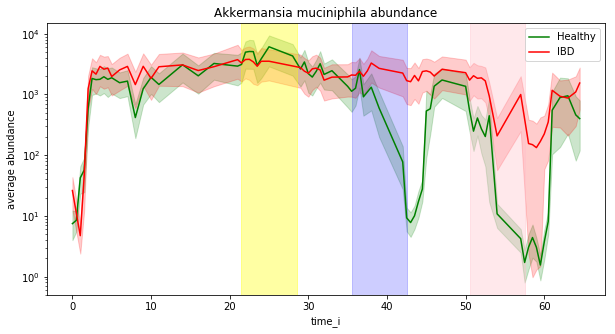

In [320]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(x="time_i", y="abundance",
             data=df_all[(df_all.genus=='Akkermansia')&(df_all.group==1)], ax=ax, color='green', label='Healthy')
sns.lineplot(x="time_i", y="abundance",
             data=df_all[(df_all.genus=='Akkermansia')&(df_all.group==2)], ax=ax, color='red', label='IBD')
ax.set_ylabel('average abundance')
ax.set_title('Akkermansia muciniphila abundance')
ax.axvspan(21.5, 28.5, alpha=0.2, color='yellow')
ax.axvspan(35.5, 42.5, alpha=0.1, color='blue')
ax.axvspan(50.5, 57.5, alpha=0.2, color='pink')
ax.axvspan(21.5, 28.5, alpha=0.2, color='yellow')
ax.axvspan(35.5, 42.5, alpha=0.1, color='blue')
ax.axvspan(50.5, 57.5, alpha=0.2, color='pink')
ax.set_yscale('log')

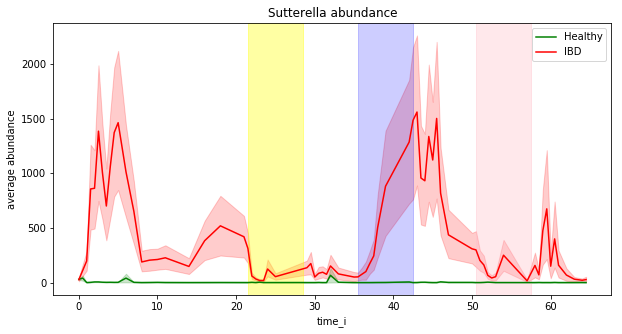

In [315]:
f, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(x="time_i", y="abundance",
             data=df_all[(df_all.genus=='Sutterella')&(df_all.group==1)], ax=ax, color='green', label='Healthy')
sns.lineplot(x="time_i", y="abundance",
             data=df_all[(df_all.genus=='Sutterella')&(df_all.group==2)], ax=ax, color='red', label='IBD')
ax.set_ylabel('average abundance')
ax.set_title('Sutterella abundance')
ax.axvspan(21.5, 28.5, alpha=0.2, color='yellow')
ax.axvspan(35.5, 42.5, alpha=0.1, color='blue')
ax.axvspan(50.5, 57.5, alpha=0.2, color='pink')
ax.axvspan(21.5, 28.5, alpha=0.2, color='yellow')
ax.axvspan(35.5, 42.5, alpha=0.1, color='blue')
ax.axvspan(50.5, 57.5, alpha=0.2, color='pink')

[ANCOM](https://www.ncbi.nlm.nih.gov/pubmed/26028277) can be applied to identify features that are differentially abundant accross phases (for example phase 1, before the first pertubation in the experiment).

In [49]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "phase='phase_1'" \
  --o-filtered-table phase_1-table.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime composition add-pseudocount \
  --i-table phase_1-table.qza \
  --o-composition-table comp-phase_1-table.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime composition ancom \
  --i-table comp-phase_1-table.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --o-visualization ancom-phase1-Group.qzv

Saved FeatureTable[Frequency] to: phase_1-table.qza
Saved FeatureTable[Composition] to: comp-phase_1-table.qza
Saved Visualization to: ancom-phase1-Group.qzv


The results below shows how sequence variants differ in abundance across healthy and disease mice in the absense of environmental pertubation.

**Bacteroides (OTU_11, OTU_9), Faecalibacterium (OTU_39), Sutterella (OTU_23), Akkermansia (OTU_3), Coprococcus (OTU_28) is more abundant in IBD mice during baseline phase (without environmental pertubation)**.

![](images/differential_abundance_phase1.jpg)

A differential abundance test at the genus taxonomic level is performed below.

In [51]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime taxa collapse \
  --i-table phase_1-table.qza \
  --i-taxonomy mouse_set_taxonomy.qza \
  --p-level 6 \
  --o-collapsed-table phase_1-table-l6.qza

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime composition add-pseudocount \
  --i-table phase_1-table-l6.qza \
  --o-composition-table comp-phase_1-table-l6.qza

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime composition ancom \
  --i-table comp-phase_1-table-l6.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --o-visualization l6-ancom-Phase.qzv

Saved FeatureTable[Frequency] to: phase_1-table-l6.qza
Saved FeatureTable[Composition] to: comp-phase_1-table-l6.qza
Saved Visualization to: l6-ancom-Phase.qzv


**Paraprevotella, Phascolarctobacterium are abundant in healthy mice, although almost absent in IBD mice.**

![](images/differential_abundance_phase1_level6.jpg)

We can view the phylogenetic tree by executing the following steps:

- open the rooted phylogenetic tree `mouse_set_data_merged-rooted-tree.qza` on https://itol.embl.de 
- drag-drop the `mouse_set_taxonomy.qza` to the viewer.

![](images/phylogenetic-tree.jpg)

## Longitudinal analysis

Linear mixed effects (LME) model tests the relationship between Shannon diversity and health status.

In [78]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime longitudinal linear-mixed-effects \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-file mouse-core-metrics-results/shannon_vector.qza \
  --p-metric shannon \
  --p-group-columns group \
  --p-state-column day \
  --p-individual-id-column mouse \
  --o-visualization mouse_linear-mixed-effects.qzv

Saved Visualization to: mouse_linear-mixed-effects.qzv


![](images/linear-mixed-effects.jpg)

In order to assess how volatile the alpha & beta diversity is over time in healthy and IBD groups, we perform valatility analysis below.

In [89]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime longitudinal volatility \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-file mouse-core-metrics-results/shannon_vector.qza \
  --m-metadata-file mouse-core-metrics-results/observed_otus_vector.qza \
  --m-metadata-file mouse-core-metrics-results/faith_pd_vector.qza \
  --m-metadata-file mouse-core-metrics-results/evenness_vector.qza \
  --p-default-metric shannon \
  --p-default-group-column group \
  --p-state-column day \
  --p-individual-id-column mouse \
  --o-visualization mouse-group-volatility.qzv

Saved Visualization to: mouse-group-volatility.qzv


![](images/volatility-control-chart-full.jpg)

## Compositional Analysis

The relationship between absolute abundance in the environment and the relative abundance after sequencing is not predictable [source](https://www.frontiersin.org/articles/10.3389/fmicb.2017.02224/full). Furthermore it is very difficult to collect exactly the same number of sequence reads for each sample, because of differences in platform  or because of technical difficulties in loading the same molar amounts of the sequencing libraries on the instrument, or because of random variation. Data that are naturally described as proportions or probabilities, or with a constant or irrelevant sum, are referred to as compositional data. Compositional data contains information about the relationships between the parts.

Three distance matrices dominate the literature: UniFrac, Bray-Curtis and Jensen-Shannon divergence. They do not account for the compositional nature of the data. They are sensitive to the total read depth of a sample, and largely discriminate between samples based on the most relatively abundant features in the samples, not on the features that are necessarily the most variable between samples.

Beta diversity is the ratio between regional and local species diversity. Compositional beta diversity captures changes in community composition [source] (https://www.frontiersin.org/articles/10.3389/fmicb.2018.01037/full). There are many beta diversity metrics that have been proposed, all with varying benefits on varying data structures [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5972327/). However, presence/absence metric often prove to give better results than those that rely on abundances. One solution to this problem is to use a compositional distance metric such as Aitchison distance. 

### Compositional analysis between experimental phases

Below we perform Robust Aitchison PCA through QIIME separetely on data from IBD and healthy mice.

Within the QIIME conda environment, we first install the QIIME [DEICODE plugin](https://library.qiime2.org/plugins/deicode/19/) by running the following command:

`pip install deicode`

DEICODE implements Aitchison Distance that is robust to high levels of sparsity. 

C. Martino et al., A Novel Sparse Compositional Technique Reveals Microbial Perturbations. mSystems. 4 (2019), doi:10.1128/mSystems.00016-19.

In [231]:
%%bash
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime deicode rpca \
    --i-table mouse_set_data_merged-IBD.qza \
    --p-min-feature-count 10 \
    --p-min-sample-count 500 \
    --o-biplot mouse-ordination-ibd.qza \
    --o-distance-matrix mouse-distance-ibd.qza

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime emperor biplot \
    --i-biplot mouse-ordination-ibd.qza \
    --m-sample-metadata-file mouse_set_metadata.tsv \
    --m-feature-metadata-file mouse_set_taxonomy.qza \
    --o-visualization mouse-biplot-ibd.qzv \
    --p-number-of-features 8
    
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime deicode rpca \
    --i-table mouse_set_data_merged-Healthy.qza \
    --p-min-feature-count 10 \
    --p-min-sample-count 500 \
    --o-biplot mouse-ordination-healthy.qza \
    --o-distance-matrix mouse-distance-healthy.qza

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime emperor biplot \
    --i-biplot mouse-ordination-healthy.qza \
    --m-sample-metadata-file mouse_set_metadata.tsv \
    --m-feature-metadata-file mouse_set_taxonomy.qza \
    --o-visualization mouse-biplot-healthy.qzv \
    --p-number-of-features 8

Saved PCoAResults % Properties(['biplot']) to: mouse-ordination-ibd.qza
Saved DistanceMatrix to: mouse-distance-ibd.qza
Saved Visualization to: mouse-biplot-ibd.qzv
Saved PCoAResults % Properties(['biplot']) to: mouse-ordination-healthy.qza
Saved DistanceMatrix to: mouse-distance-healthy.qza
Saved Visualization to: mouse-biplot-healthy.qzv


We additionally run PERMANOVA on the distances to get a statistical significance. 

In [233]:
 %%bash
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity beta-group-significance \
    --i-distance-matrix mouse-distance-ibd.qza \
    --m-metadata-file mouse_set_metadata.tsv \
    --m-metadata-column phase \
    --p-method permanova \
    --o-visualization mouse-distance-ibd_significance.qzv

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime diversity beta-group-significance \
    --i-distance-matrix mouse-distance-healthy.qza \
    --m-metadata-file mouse_set_metadata.tsv \
    --m-metadata-column phase \
    --p-method permanova \
    --o-visualization mouse-distance-healthy_significance.qzv

Saved Visualization to: mouse-distance-ibd_significance.qzv
Saved Visualization to: mouse-distance-healthy_significance.qzv


Below we can see a Biplot that allows us to represent the features that strongly influence the principal component axis as arrows. The log ratio between features is represented by arrows pointing in different directions. From this visualization we noticed that the experimental phase seems to explain two clusters well. The baseline phase 1 together with high-fat diet (phase 2) and the following washout phase 3 form the first big cluster. The antibiotic phases 4 and 6 together with their corresponding washout periods build the second big cluster. **The genus Blautia (Lachnospiraceae) significantly (PERMANOVA, pseudo-F, p<0.001) impacts the bacterial composition under antibiotics in IBD mice.**

![](images/biplot-mouse-ibd-phase.jpg)

**The genus Ovatus, Uniformis, Escherichia/Shigella significantly (PERMANOVA, pseudo-F, p<0.001) influence composition on healthy individuals, but not on IBD mice**

![](images/biplot-mouse-healthy-phase.jpg)

**Sutterella, Clostridium, Muciniphila, Hathewayi and Bacteroides appear on both IBD and healthy mice, as factors of significant compositional diversity between phases.**

### Compositional analysis between healthy and IBD mice in baseline phase 1

Below we perform Robust Aitchison PCA analysis on all samples measured on all mice (healthy and IBD) during the baseline phase, prior to pertubation. We are interested in identifying species which explain most of the differential bacterial composition at rest.


In [235]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "phase='phase_1'" \
  --o-filtered-table mouse_set_data_merged-Phase1.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime deicode rpca \
    --i-table mouse_set_data_merged-Phase1.qza \
    --p-min-feature-count 10 \
    --p-min-sample-count 500 \
    --o-biplot mouse-ordination-Phase1.qza \
    --o-distance-matrix mouse-distance-Phase1.qza

/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime emperor biplot \
    --i-biplot mouse-ordination-Phase1.qza \
    --m-sample-metadata-file mouse_set_metadata.tsv \
    --m-feature-metadata-file mouse_set_taxonomy.qza \
    --o-visualization mouse-biplot-Phase1.qzv \
    --p-number-of-features 8

Saved FeatureTable[Frequency] to: mouse_set_data_merged-Phase1.qza
Saved PCoAResults % Properties(['biplot']) to: mouse-ordination-Phase1.qza
Saved DistanceMatrix to: mouse-distance-Phase1.qza
Saved Visualization to: mouse-biplot-Phase1.qzv


The biplot below shows a clear separation between healthy and IBD mice clusters. Outliers building the third cluster are all from samples taken on day 0 and day 1. This result suggests to remove both days from our analysis, as they do not significantly contribute in distinguishing disease from healthy mice. 

Next to the dominant Bacteroides genus (species Ovatus, uniformis), **the composition of following genus are found to clearly differenciate healthy from IBD mice in the baseline phase: Parasutterella, Escherichia/Shigella, Akkermansia.**

![](images/biplot-mouse-phase1.jpg)

## Features Importance

Supervised learning classifiers predict the categorical metadata classes of unlabeled samples by learning the composition of labeled training samples. Below we predict the experimental phase (baseline, high-fat diet, gram- antibiotics, gram+ antibiotics or washout) based on stool microbiome composition in IBD mice. A RandomForest classifier is used, with 20 trees. 5-fold cross-validation is performed during automatic feature selection.

In [229]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "mouse in ('mouse_06','mouse_07','mouse_08','mouse_09','mouse_10')" \
  --o-filtered-table mouse_set_data_merged-IBD.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "mouse in ('mouse_02','mouse_03','mouse_04','mouse_05')" \
  --o-filtered-table mouse_set_data_merged-Healthy.qza

Saved FeatureTable[Frequency] to: mouse_set_data_merged-IBD.qza
Saved FeatureTable[Frequency] to: mouse_set_data_merged-Healthy.qza


In [121]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime sample-classifier classify-samples \
  --i-table mouse_set_data_merged-IBD.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column phase \
  --p-optimize-feature-selection \
  --p-parameter-tuning \
  --p-estimator RandomForestClassifier \
  --p-n-estimators 20 \
  --p-random-state 123 \
  --output-dir mouse-IBD-classifier
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-features \
  --i-table mouse_set_data_merged-IBD.qza \
  --m-metadata-file mouse-IBD-classifier/feature_importance.qza \
  --o-filtered-table mouse-IBD-classifier/important-feature-table.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime metadata tabulate \
  --m-input-file mouse-IBD-classifier/feature_importance.qza \
  --o-visualization mouse-IBD-classifier/feature_importance.qzv
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime metadata tabulate \
  --m-input-file mouse-IBD-classifier/important-feature-table.qza \
  --o-visualization mouse-IBD-classifier/important-feature-table.qzv

Saved SampleEstimator[Classifier] to: mouse-IBD-classifier/sample_estimator.qza
Saved FeatureData[Importance] to: mouse-IBD-classifier/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: mouse-IBD-classifier/predictions.qza
Saved Visualization to: mouse-IBD-classifier/model_summary.qzv
Saved Visualization to: mouse-IBD-classifier/accuracy_results.qzv


Overall accuracy is 94.52%. 
![](images/classifier-accuracy-phase-IBD.jpg)

**The most important features affected by environmental pertubation in IBD mice are the following genus: Blautia (OTU_49, OTU_33), Faecalibacterium (OTU_39), Ruminococcus (OTU_112), Clostridium_XlVa (OTU_185,OTU_43, OTU_45)**
![](images/classifier-features-importance-phase-IBD.jpg)

Below we run a randomforest classifier on samples recorded in phase 4 where mice were given Gram+ ABX antibiotics. The predicted variable is the health status. Features are OTUs.

**We obtain 100% classification accuracy, with the following genus being those which differenciate healthy mice from IBD mice under Gram+ ABX treatement with the highest significance: Bacteroides (OTU_36, OTU_12), Phascolarctobacterium(OTU_17), Parabacteroides (OTU_16), Bilophila (OTU_24).**

In [135]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "phase='phase_4'" \
  --o-filtered-table mouse_set_data_merged-Phase4.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime sample-classifier classify-samples \
  --i-table mouse_set_data_merged-Phase4.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --p-optimize-feature-selection \
  --p-parameter-tuning \
  --p-estimator RandomForestClassifier \
  --p-n-estimators 20 \
  --p-random-state 123 \
  --output-dir mouse-Phase4-classifier
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-features \
  --i-table mouse_set_data_merged-Phase4.qza \
  --m-metadata-file mouse-Phase4-classifier/feature_importance.qza \
  --o-filtered-table mouse-Phase4-classifier/important-feature-table.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime metadata tabulate \
  --m-input-file mouse-Phase4-classifier/feature_importance.qza \
  --o-visualization mouse-Phase4-classifier/feature_importance.qzv

Saved FeatureTable[Frequency] to: mouse_set_data_merged-Phase4.qza
Saved SampleEstimator[Classifier] to: mouse-Phase4-classifier/sample_estimator.qza
Saved FeatureData[Importance] to: mouse-Phase4-classifier/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: mouse-Phase4-classifier/predictions.qza
Saved Visualization to: mouse-Phase4-classifier/model_summary.qzv
Saved Visualization to: mouse-Phase4-classifier/accuracy_results.qzv
Saved FeatureTable[Frequency] to: mouse-Phase4-classifier/important-feature-table.qza
Saved Visualization to: mouse-Phase4-classifier/feature_importance.qzv


We build a similar classifier as above, this time in the Gram- ABX antibiotics treatement phase.

**We obtain 93.33% classification accuracy, Blautia (OTU_88) is the only genus which differenciates healthy mice from IBD mice under Gram- ABX treatement with the highest significance.**

In [136]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "phase='phase_6'" \
  --o-filtered-table mouse_set_data_merged-Phase6.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime sample-classifier classify-samples \
  --i-table mouse_set_data_merged-Phase6.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --p-optimize-feature-selection \
  --p-parameter-tuning \
  --p-estimator RandomForestClassifier \
  --p-n-estimators 20 \
  --p-random-state 123 \
  --output-dir mouse-Phase6-classifier
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-features \
  --i-table mouse_set_data_merged-Phase6.qza \
  --m-metadata-file mouse-Phase6-classifier/feature_importance.qza \
  --o-filtered-table mouse-Phase6-classifier/important-feature-table.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime metadata tabulate \
  --m-input-file mouse-Phase6-classifier/feature_importance.qza \
  --o-visualization mouse-Phase6-classifier/feature_importance.qzv

Saved FeatureTable[Frequency] to: mouse_set_data_merged-Phase6.qza
Saved SampleEstimator[Classifier] to: mouse-Phase6-classifier/sample_estimator.qza
Saved FeatureData[Importance] to: mouse-Phase6-classifier/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: mouse-Phase6-classifier/predictions.qza
Saved Visualization to: mouse-Phase6-classifier/model_summary.qzv
Saved Visualization to: mouse-Phase6-classifier/accuracy_results.qzv
Saved FeatureTable[Frequency] to: mouse-Phase6-classifier/important-feature-table.qza
Saved Visualization to: mouse-Phase6-classifier/feature_importance.qzv


We build another classifier, this time in the High-Fat diet phase.

**We obtain 100% classification accuracy. The following genus differenciate healthy mice from IBD mice under high-fat diet with the highest significance: Clostridium_XlVa (OTU_150), Blautia (OTU_94), Faecalibacterium (OTU_122), Clostridium_IV (OTU_149), Lactonifactor (OTU_63), Pseudoflavonifractor (OTU_145), Parabacteroides (OTU_16), Faecalibacterium (OTU_115), Butyricicoccus (OTU_133), Ruminococcus (OTU_123).**

In [137]:
%%bash -e
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-samples \
  --i-table mouse_set_data_merged.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --p-where "phase='phase_2'" \
  --o-filtered-table mouse_set_data_merged-Phase2.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime sample-classifier classify-samples \
  --i-table mouse_set_data_merged-Phase2.qza \
  --m-metadata-file mouse_set_metadata.tsv \
  --m-metadata-column group \
  --p-optimize-feature-selection \
  --p-parameter-tuning \
  --p-estimator RandomForestClassifier \
  --p-n-estimators 20 \
  --p-random-state 123 \
  --output-dir mouse-Phase2-classifier
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime feature-table filter-features \
  --i-table mouse_set_data_merged-Phase2.qza \
  --m-metadata-file mouse-Phase2-classifier/feature_importance.qza \
  --o-filtered-table mouse-Phase2-classifier/important-feature-table.qza
  
/usr/share/anaconda3/envs/qiime2-2019.1/bin/qiime metadata tabulate \
  --m-input-file mouse-Phase2-classifier/feature_importance.qza \
  --o-visualization mouse-Phase2-classifier/feature_importance.qzv

Saved FeatureTable[Frequency] to: mouse_set_data_merged-Phase2.qza
Saved SampleEstimator[Classifier] to: mouse-Phase2-classifier/sample_estimator.qza
Saved FeatureData[Importance] to: mouse-Phase2-classifier/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: mouse-Phase2-classifier/predictions.qza
Saved Visualization to: mouse-Phase2-classifier/model_summary.qzv
Saved Visualization to: mouse-Phase2-classifier/accuracy_results.qzv
Saved FeatureTable[Frequency] to: mouse-Phase2-classifier/important-feature-table.qza
Saved Visualization to: mouse-Phase2-classifier/feature_importance.qzv
